In [25]:
import argparse
import numpy as np
import torch
import torch.nn as nn

In [26]:
# S: Symbol that shows starting of decoding input
# E: Symbol that shows starting of decoding output
# P: Symbol that will fill in blank sequence if current batch data size is short than time steps

def make_batch():
  input_batch, output_batch, target_batch = [], [], []

  for seq in seq_data:
    for i in range(2):
        seq[i] = seq[i] + 'P' * (n_step - len(seq[i]))

    input = [num_dic[n] for n in seq[0]]
    output = [num_dic[n] for n in ('S' + seq[1])]
    target = [num_dic[n] for n in (seq[1] + 'E')]

    input_batch.append(np.eye(n_class)[input])
    output_batch.append(np.eye(n_class)[output])
    target_batch.append(target) # not one-hot

  # make tensor
  return torch.FloatTensor(input_batch), torch.FloatTensor(output_batch), torch.LongTensor(target_batch)

In [27]:
# Model
class Seq2Seq(nn.Module):
  def __init__(self):
    super(Seq2Seq, self).__init__()

    self.enc_cell = nn.RNN(input_size=n_class, hidden_size=n_hidden, dropout=0.5)
    self.dec_cell = nn.RNN(input_size=n_class, hidden_size=n_hidden, dropout=0.5)
    self.fc = nn.Linear(n_hidden, n_class)

  def forward(self, enc_input, enc_hidden, dec_input):
    enc_input = enc_input.transpose(0, 1) # enc_input: [max_len(=n_step, time step), batch_size, n_class]
    dec_input = dec_input.transpose(0, 1) # dec_input: [max_len(=n_step, time step), batch_size, n_class]

    # enc_states : [num_layers(=1) * num_directions(=1), batch_size, n_hidden]
    _, enc_states = self.enc_cell(enc_input, enc_hidden)
    # outputs : [max_len+1(=6), batch_size, num_directions(=1) * n_hidden(=128)]
    outputs, _ = self.dec_cell(dec_input, enc_states)

    model = self.fc(outputs) # model : [max_len+1(=6), batch_size, n_class]
    return model

In [28]:
n_step = 5
n_hidden = 128

char_arr = [c for c in 'SEPabcdefghijklmnopqrstuvwxyz']
num_dic = {n: i for i, n in enumerate(char_arr)}
seq_data = [['man', 'women'], ['black', 'white'], ['king', 'queen'], ['girl', 'boy'], ['up', 'down'], ['high', 'low']]

n_class = len(num_dic)
batch_size = len(seq_data)

model = Seq2Seq()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

input_batch, output_batch, target_batch = make_batch()

for epoch in range(5000):
    # make hidden shape [num_layers * num_directions, batch_size, n_hidden]
    hidden = torch.zeros(1, batch_size, n_hidden)

    optimizer.zero_grad()
    # input_batch : [batch_size, max_len(=n_step, time step), n_class]
    # output_batch : [batch_size, max_len+1(=n_step, time step) (becase of 'S' or 'E'), n_class]
    # target_batch : [batch_size, max_len+1(=n_step, time step)], not one-hot
    output = model(input_batch, hidden, output_batch)
    # output : [max_len+1, batch_size, n_class]
    output = output.transpose(0, 1) # [batch_size, max_len+1(=6), n_class]
    loss = 0
    for i in range(0, len(target_batch)):
        # output[i] : [max_len+1, n_class, target_batch[i] : max_len+1]
        loss += criterion(output[i], target_batch[i])
    if (epoch + 1) % 1000 == 0:
        print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))
    loss.backward()
    optimizer.step()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
<ipython-input-26-8a437a402612>:21: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  return torch.FloatTensor(input_batch), torch.FloatTensor(output_batch), torch.LongTensor(target_batch)


Epoch: 1000 cost = 0.003759
Epoch: 2000 cost = 0.001021
Epoch: 3000 cost = 0.000434
Epoch: 4000 cost = 0.000217
Epoch: 5000 cost = 0.000117


In [29]:
input_batch, output_batch, _ = make_batch()

# make hidden shape [num_layers * num_directions, batch_size, n_hidden]
hidden = torch.zeros(1, 6, 128)
for i in range(0, len(input_batch)):
  output = model(input_batch, hidden, output_batch)
  # output : [max_len+1(=6), batch_size(=1), n_class]

  output = output.transpose(0, 1)
  output = torch.argmax(output.data, -1)[i].numpy()

  decode = [char_arr[c] for c in output]

  end = decode.index('E')
  translated = ''.join(decode[:end])

  input_word = [char_arr[w] for w in input_batch[i].max(-1)[1]]
  input_word = ''.join(input_word[:end])
  print(f"{input_word.replace('P', '')} -> {translated.replace('P', '')}")

man -> women
black -> white
king -> queen
girl -> boy
up -> down
high -> low


# Keras

In [2]:
import pandas as pd
import numpy as np
import string
from string import digits

%matplotlib inline
import re

In [3]:
!wget https://raw.githubusercontent.com/devm2024/nmt_keras/master/fra.txt

--2023-06-22 20:39:04--  https://raw.githubusercontent.com/devm2024/nmt_keras/master/fra.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10481325 (10.0M) [text/plain]
Saving to: ‘fra.txt’

fra.txt             100%[===================>]  10.00M  --.-KB/s    in 0.05s   

2023-06-22 20:39:05 (184 MB/s) - ‘fra.txt’ saved [10481325/10481325]



In [40]:
lines= pd.read_table('fra.txt', names=['eng', 'fr'])

In [41]:
lines = lines[:400]

In [42]:
def preprocess():
  lines.eng=lines.eng.apply(lambda x: x.lower())
  lines.fr=lines.fr.apply(lambda x: x.lower())
  lines.eng=lines.eng.apply(lambda x: re.sub("'", '', x)).apply(lambda x: re.sub(",", ' COMMA', x))
  lines.fr=lines.fr.apply(lambda x: re.sub("'", '', x)).apply(lambda x: re.sub(",", ' COMMA', x))
  exclude = set(string.punctuation)
  lines.eng=lines.eng.apply(lambda x: ''.join(ch for ch in x if ch not in exclude))
  lines.fr=lines.fr.apply(lambda x: ''.join(ch for ch in x if ch not in exclude))
  remove_digits = str.maketrans('', '', digits)
  lines.eng=lines.eng.apply(lambda x: x.translate(remove_digits))
  lines.fr=lines.fr.apply(lambda x: x.translate(remove_digits))
  lines.fr = lines.fr.apply(lambda x : 'START_ '+ x + ' _END')

preprocess()
lines.head()

,eng,fr
0,go,START_ va _END
1,run,START_ cours _END
2,run,START_ courez _END
3,wow,START_ ça alors _END
4,fire,START_ au feu _END


In [43]:
all_eng_words=set()
for eng in lines.eng:
    for word in eng.split():
        if word not in all_eng_words:
            all_eng_words.add(word)

all_french_words=set()
for fr in lines.fr:
    for word in fr.split():
        if word not in all_french_words:
            all_french_words.add(word)

In [44]:
input_words = sorted(list(all_eng_words))
target_words = sorted(list(all_french_words))
num_encoder_tokens = len(all_eng_words)
num_decoder_tokens = len(all_french_words)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])
print(num_encoder_tokens)
print(num_decoder_tokens)

178
395


In [45]:
input_token_index = dict(
    [(word, i) for i, word in enumerate(input_words)])
target_token_index = dict(
    [(word, i) for i, word in enumerate(target_words)])

In [46]:
print(input_token_index)

{'COMMA': 0, 'a': 1, 'agree': 2, 'ahead': 3, 'am': 4, 'ask': 5, 'attack': 6, 'away': 7, 'awesome': 8, 'back': 9, 'bald': 10, 'be': 11, 'beat': 12, 'beats': 13, 'busy': 14, 'call': 15, 'calm': 16, 'came': 17, 'cheer': 18, 'cheers': 19, 'cold': 20, 'come': 21, 'cool': 22, 'cuff': 23, 'cute': 24, 'deaf': 25, 'deep': 26, 'did': 27, 'died': 28, 'done': 29, 'down': 30, 'drive': 31, 'drop': 32, 'failed': 33, 'fair': 34, 'fast': 35, 'fat': 36, 'fell': 37, 'find': 38, 'fine': 39, 'fire': 40, 'fit': 41, 'forgot': 42, 'free': 43, 'full': 44, 'fun': 45, 'get': 46, 'glad': 47, 'go': 48, 'good': 49, 'goodbye': 50, 'got': 51, 'grab': 52, 'guys': 53, 'hang': 54, 'hard': 55, 'have': 56, 'he': 57, 'help': 58, 'helps': 59, 'here': 60, 'hes': 61, 'hi': 62, 'him': 63, 'his': 64, 'hit': 65, 'hold': 66, 'home': 67, 'hop': 68, 'how': 69, 'hug': 70, 'humor': 71, 'hurry': 72, 'hurts': 73, 'i': 74, 'ill': 75, 'im': 76, 'in': 77, 'it': 78, 'its': 79, 'ive': 80, 'job': 81, 'join': 82, 'jump': 83, 'keep': 84, 'kind

In [47]:
input_token_index = dict(
    [(char, i) for i, char in enumerate(input_words)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_words)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.

NameError: ignored

In [11]:
embedding_size = 50

In [33]:
from keras.layers import Input, LSTM, Embedding, Dense
from keras.models import Model
# from keras.utils import plot_model

In [34]:
encoder_inputs = Input(shape=(None,))
en_x=  Embedding(num_encoder_tokens, embedding_size)(encoder_inputs)
encoder = LSTM(50, return_state=True)
encoder_outputs, state_h, state_c = encoder(en_x)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

In [35]:
decoder_inputs = Input(shape=(None,))
dex=  Embedding(num_decoder_tokens, embedding_size)
final_dex= dex(decoder_inputs)

decoder_lstm = LSTM(50, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(final_dex, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [36]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [39]:
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=128,
          epochs=50,
          validation_split=0.05)

ValueError: ignored

In [17]:
encoder_model = Model(encoder_inputs, encoder_states)

In [18]:
decoder_state_input_h = Input(shape=(50,))
decoder_state_input_c = Input(shape=(50,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

final_dex2= dex(decoder_inputs)

decoder_outputs2, state_h2, state_c2 = decoder_lstm(final_dex2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]
decoder_outputs2 = decoder_dense(decoder_outputs2)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())

In [19]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = target_token_index['START_']

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += ' '+sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '_END' or
           len(decoded_sentence) > 52):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]

    return decoded_sentence

In [24]:
for seq_index in [99,2,45,40]:
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print(input_seq)
    print('Input sentence:', lines.eng[seq_index: seq_index + 1])
    print('Decoded sentence:', decoded_sentence)

1/1 [==============================] - 0s 42ms/step
-
[[0. 0. 0. 0. 0. 0. 0.]]
Input sentence: 99    drop it
Name: eng, dtype: object
Decoded sentence:  quelle quelle quelle quelle quelle quelle quelle quelle
1/1 [==============================] - 0s 35ms/step
-
[[0. 0. 0. 0. 0. 0. 0.]]
Input sentence: 2    run
Name: eng, dtype: object
Decoded sentence:  quelle quelle quelle quelle quelle quelle quelle quelle
1/1 [==============================] - 0s 24ms/step
-
[[0. 0. 0. 0. 0. 0. 0.]]
Input sentence: 45    im 
Name: eng, dtype: object
Decoded sentence:  quelle quelle quelle quelle quelle quelle quelle quelle
1/1 [==============================] - 0s 27ms/step
-
[[0. 0. 0. 0. 0. 0. 0.]]
Input sentence: 40    i fell
Name: eng, dtype: object
Decoded sentence:  quelle quelle quelle quelle quelle quelle quelle quelle


# Tensorflow

In [ ]:
!pip install tensorflow_text

     |████████████████████████████████| 4.3MB 6.8MB/s 


In [ ]:
import numpy as np

import typing
from typing import Any, Tuple

import tensorflow as tf
from tensorflow.keras.layers import Embedding, GRU, Layer
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.python.ops import math_ops

import tensorflow_text as tf_text

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [ ]:
# Download the file
import pathlib

path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True)

path_to_file = pathlib.Path(path_to_zip).parent/'spa-eng/spa.txt'

2646016/2638744 [==============================] - 0s 0us/step


In [ ]:
def load_data(path):
  text = path_to_file.read_text(encoding='utf-8')

  lines = text.splitlines()
  pairs = [line.split('\t') for line in lines]

  inp = [inp for targ, inp in pairs]
  targ = [targ for targ, inp in pairs]

  return targ, inp

In [ ]:
targ, inp = load_data(path_to_file)
print(inp[-1])
print(targ[-1])

Si quieres sonar como un hablante nativo, debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un músico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado.
If you want to sound like a native speaker, you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo.


In [ ]:
BUFFER_SIZE = len(inp)
BATCH_SIZE = 64

dataset = tf.data.Dataset.from_tensor_slices((inp, targ)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)

In [ ]:
def tf_lower_and_split_punct(text):
  # Split accecented characters.
  text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)
  # Keep space, a to z, and select punctuation.
  text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
  # Add spaces around punctuation.
  text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
  # Strip whitespace.
  text = tf.strings.strip(text)

  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text


In [ ]:
for spanish, english in dataset.take(1):
  pass
print(spanish[0].numpy().decode())
print(tf_lower_and_split_punct(spanish[0]).numpy().decode())

Es un problema que no podemos resolver.
[START] es un problema que no podemos resolver . [END]


In [ ]:
max_vocab_size = 400

input_text_processor = preprocessing.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size)

input_text_processor.adapt(inp)

# Here are the first 10 words from the vocabulary:
input_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', 'que', 'de', 'el', 'a', 'no']

In [ ]:
output_text_processor = preprocessing.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size)

output_text_processor.adapt(targ)
output_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', 'the', 'i', 'to', 'you', 'tom']

In [ ]:
class Encoder(Layer):
  def __init__(self, input_vocab_size, embedding_dim, enc_units):
    super(Encoder, self).__init__()
    self.enc_units = enc_units
    self.input_lang_embedding = Embedding(input_vocab_size, embedding_dim)
    self.gru = GRU(self.enc_units,
                                   # Return the sequence and state
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, word_indices, state=None):
    word_embeddings =  self.input_lang_embedding(word_indices)
    whole_sequence_output, final_state = self.gru(word_embeddings)
    return whole_sequence_output, final_state

In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
      super().__init__()
      self.W1 = tf.keras.layers.Dense(units, use_bias=False)
      self.W2 = tf.keras.layers.Dense(units, use_bias=False)

  def call(self, query, keys, mask):
      query_weights = tf.expand_dims(self.W1(query), 2)
      keys_weights = tf.expand_dims(self.W2(keys), 1)
      score = tf.reduce_sum(tf.nn.tanh(query_weights + keys_weights), -1)
      padding_mask = tf.expand_dims(math_ops.logical_not(mask), 1)
      score -= 1e9 * math_ops.cast(padding_mask, dtype=score.dtype)
      attention_scores = tf.expand_dims(tf.nn.softmax(score, axis=2), -1)
      context = tf.reduce_sum(attention_scores * tf.expand_dims(keys, axis=1), axis=2)
      return context, attention_scores,


In [ ]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, output_vocab_size, embedding_dim, dec_units):
    super(Decoder, self).__init__()
    self.english_embedding = Embedding(output_vocab_size, embedding_dim)
    self.gru = GRU(dec_units, return_sequences=True, return_state=True)
    self.dense = tf.keras.layers.Dense(output_vocab_size)
    self.attention = BahdanauAttention(dec_units)

  def call(self, input_word_indices, encoder_keys, mask, state=None):
    embedding_ = self.english_embedding(input_word_indices)
    output, state = self.gru(embedding_, initial_state=state)
    context, attention_scores = self.attention(query=output,
                                              keys=encoder_keys,
                                              mask = mask)
    concat = tf.concat([output, context], axis=-1)


    vocab_output = self.dense(concat)

    return vocab_output, state

In [ ]:
class ModelTrain(tf.keras.Model):
  def __init__(self, input_text_processor, output_text_processor, embedding_dim, units):
    super(ModelTrain, self).__init__()
    self.encoder = Encoder(input_text_processor.vocabulary_size(), embedding_dim, units)
    self.decoder = Decoder(output_text_processor.vocabulary_size(), embedding_dim, units)
    self.input_text_processor = input_text_processor
    self.output_text_processor = output_text_processor

  @tf.function
  def train_step(self, data):
    input_sentence, output_sentence = data
    input_word_indices = self.input_text_processor(input_sentence)
    output_word_indices = self.output_text_processor(output_sentence)
    output_mask = tf.cast(output_word_indices != 0, tf.float32)

    with tf.GradientTape() as tape:
      whole_encoder_states, final_hidden_state = self.encoder(input_word_indices)
      vocab_output, decoder_last_state = self.decoder(input_word_indices=output_word_indices,
                                                      encoder_keys = whole_encoder_states,
                                                      mask = (input_word_indices != 0),
                                                      state=final_hidden_state )

      loss = tf.reduce_sum(self.loss(y_true=output_word_indices[:, 1:], y_pred=vocab_output[:, :-1]) * output_mask[:, 1:])
    variables = self.trainable_variables
    gradients = tape.gradient(loss, variables)
    self.optimizer.apply_gradients(zip(gradients, variables))
    return {'loss': loss}


In [ ]:
model = ModelTrain(input_text_processor, output_text_processor, 300, 128)

model.compile(
    optimizer=tf.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
)

In [ ]:
model.fit(dataset, epochs=10)

Epoch 1/10
1859/1859 [==============================] - 26s 12ms/step - loss: 1083.8786
Epoch 2/10
1859/1859 [==============================] - 22s 12ms/step - loss: 694.3065
Epoch 3/10
1859/1859 [==============================] - 22s 12ms/step - loss: 624.9959
Epoch 4/10
1859/1859 [==============================] - 22s 12ms/step - loss: 585.1982
Epoch 5/10
1859/1859 [==============================] - 22s 12ms/step - loss: 556.9671
Epoch 6/10
1859/1859 [==============================] - 21s 11ms/step - loss: 535.1006
Epoch 7/10
1859/1859 [==============================] - 21s 11ms/step - loss: 517.7254
Epoch 8/10
1859/1859 [==============================] - 21s 11ms/step - loss: 503.0345
Epoch 9/10
1859/1859 [==============================] - 21s 11ms/step - loss: 490.5161
Epoch 10/10
1859/1859 [==============================] - 21s 11ms/step - loss: 479.4623


In [ ]:
class Infer(tf.Module):
  def __init__(self,encoder, decoder,
               input_text_processor,
               output_text_processor):
    self.encoder = encoder
    self.decoder = decoder
    self.input_text_processor = input_text_processor
    self.output_text_processor = output_text_processor

    self.idx_to_word = (
        tf.keras.layers.experimental.preprocessing.StringLookup(
            vocabulary=output_text_processor.get_vocabulary(),
            invert=True))

    # The output should never generate padding, unknown, or start.
    index_from_string = tf.keras.layers.experimental.preprocessing.StringLookup(
      vocabulary=output_text_processor.get_vocabulary())

    token_mask_ids = index_from_string(['',
                                    '[UNK]',
                                    '[START]']).numpy()

    token_mask = np.zeros([index_from_string.vocabulary_size()], dtype=np.bool)
    token_mask[np.array(token_mask_ids)] = True
    self.token_mask = token_mask[tf.newaxis, tf.newaxis, :]


    self.start_token = index_from_string('[START]')
    self.end_token = index_from_string('[END]')

  def tokens_to_text(self, result_tokens):
    result_text_tokens = self.idx_to_word(result_tokens)

    result_text = tf.strings.reduce_join(result_text_tokens,
                                        axis=1, separator=' ')

    result_text = tf.strings.strip(result_text)
    return result_text

  def sample(self, logits):
    logits = tf.where(self.token_mask, -np.inf, logits)
    return tf.argmax(logits, axis=-1)

  def translate(self, input_sentence, max_length=50,):
    batch_size = tf.shape(input_sentence)[0]
    input_word_indices = self.input_text_processor(input_sentence)
    input_mask = (input_word_indices != 0)
    whole_encoder_output, final_hidden_state = self.encoder(input_word_indices)
    dec_state = final_hidden_state
    vocab_input = tf.fill([batch_size, 1], self.start_token)
    result_tokens = []
    done = tf.zeros([batch_size, 1], dtype=tf.bool)
    for current_length in range(max_length):
      vocab_output, dec_state = self.decoder(input_word_indices=vocab_input,
                                             encoder_keys=whole_encoder_output,
                                             mask= input_mask, state= dec_state)
      vocab_input = self.sample(vocab_output)


      done = done | (vocab_input == self.end_token)
      vocab_input = tf.where(done, tf.constant(0, dtype=tf.int64), vocab_input)
      result_tokens.append(vocab_input)

      if tf.reduce_all(done):
        break

    result_tokens = tf.concat(result_tokens, axis=-1)
    result_text = self.tokens_to_text(result_tokens)
    return {'text': result_text}

In [ ]:
infer = Infer(model.encoder, model.decoder, input_text_processor, output_text_processor)

In [ ]:
infer.translate(["Te quiero.", "mi pasaporte esta aqui", "¿Dónde está el hotel?", "Quiero irme a casa hoy.", "La tierra gira alrededor del sol."])['text'].numpy()

array([b'i love you .', b'my wife is here here .', b'where is the bus ?',
       b'i want to go home today .',
       b'the girl was late for the of the bus .'], dtype=object)

In [48]:
import os, sys, time, random
import h5py
import numpy as np

In [49]:
from keras.layers import *
from keras.models import *
from keras.utils import *
from keras.initializers import *
import tensorflow as tf

In [50]:
batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.
# Path to the data txt file on disk.
data_path = "fra.txt"

In [51]:
# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text = line.split('\t')
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

In [52]:
print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

Number of samples: 10000
Number of unique input tokens: 71
Number of unique output tokens: 94
Max sequence length for inputs: 16
Max sequence length for outputs: 59


In [53]:
input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.

In [54]:
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)
# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [55]:
model.summary()
# print(model.layers[-1].input)
print(model.layers[-3].output)

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, None, 71)]   0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, None, 94)]   0           []                               
                                                                                                  
 lstm_4 (LSTM)                  [(None, 256),        335872      ['input_7[0][0]']                
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                            

In [56]:
print("encoder_input_data shape:",encoder_input_data.shape)
print("decoder_input_data shape:",decoder_input_data.shape)
print("decoder_target_data shape:",decoder_target_data.shape)

encoder_input_data shape: (10000, 16, 71)
decoder_input_data shape: (10000, 59, 94)
decoder_target_data shape: (10000, 59, 94)


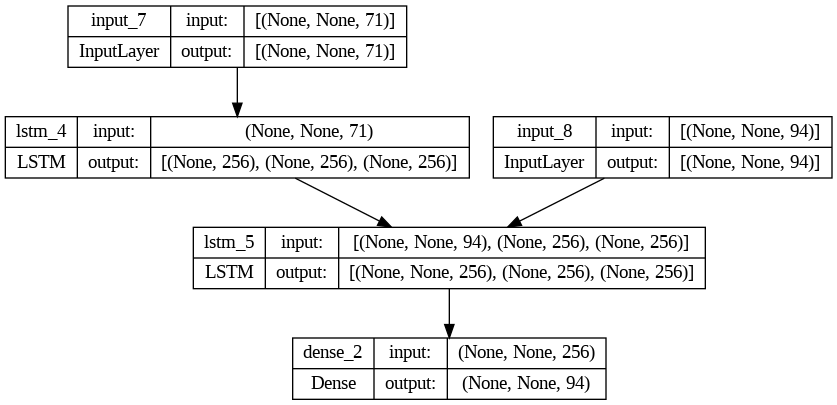

In [57]:
plot_model(model,show_shapes=True)

In [58]:
# Run training
from keras.optimizers import *
model.compile(optimizer=Adam(lr=0.01, beta_1=0.9, beta_2=0.999, decay=0.001), loss='categorical_crossentropy')
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/100
125/125 [==============================] - 6s 21ms/step - loss: 0.9629 - val_loss: 1.0740
Epoch 2/100
125/125 [==============================] - 1s 12ms/step - loss: 0.8817 - val_loss: 1.0396
Epoch 3/100
125/125 [==============================] - 1s 12ms/step - loss: 0.8365 - val_loss: 0.9684
Epoch 4/100
125/125 [==============================] - 2s 14ms/step - loss: 0.7898 - val_loss: 0.9264
Epoch 5/100
125/125 [==============================] - 2s 13ms/step - loss: 0.7506 - val_loss: 0.8800
Epoch 6/100
125/125 [==============================] - 1s 12ms/step - loss: 0.6999 - val_loss: 0.8348
Epoch 7/100
125/125 [==============================] - 1s 11ms/step - loss: 0.6579 - val_loss: 0.7820
Epoch 8/100
125/125 [==============================] - 2s 15ms/step - loss: 0.6393 - val_loss: 0.7888
Epoch 9/100
125/125 [==============================] - 2s 15ms/step - loss: 0.6046 - val_loss: 0.7198
Epoch 10/100
125/125 [==============================] - 2s 13ms/step - loss: 0.570

In [59]:
# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

In [60]:
# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())


def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence

In [61]:
for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

1/1 [==============================] - 0s 25ms/step
-
Input sentence: Go.
Decoded sentence: Cons mai.

1/1 [==============================] - 0s 23ms/step
-
Input sentence: Run!
Decoded sentence: Courez !

1/1 [==============================] - 0s 44ms/step
-
Input sentence: Run!
Decoded sentence: Courez !

1/1 [==============================] - 0s 177ms/step
-
Input sentence: Wow!
Decoded sentence: Quelle prou.

1/1 [==============================] - 0s 69ms/step
-
Input sentence: Fire!
Decoded sentence: Au feu.

1/1 [==============================] - 0s 24ms/step
-
Input sentence: Help!
Decoded sentence: Monter.

1/1 [==============================] - 0s 31ms/step
-
Input sentence: Jump.
Decoded sentence: Sarte.

1/1 [==============================] - 0s 25ms/step
-
Input sentence: Stop!
Decoded sentence: Arrête-toi.

1/1 [==============================] - 0s 23ms/step
-
Input sentence: Stop!
Decoded sentence: Arrête-toi.

1/1 [==============================] - 0s 24ms/step
-
Input s